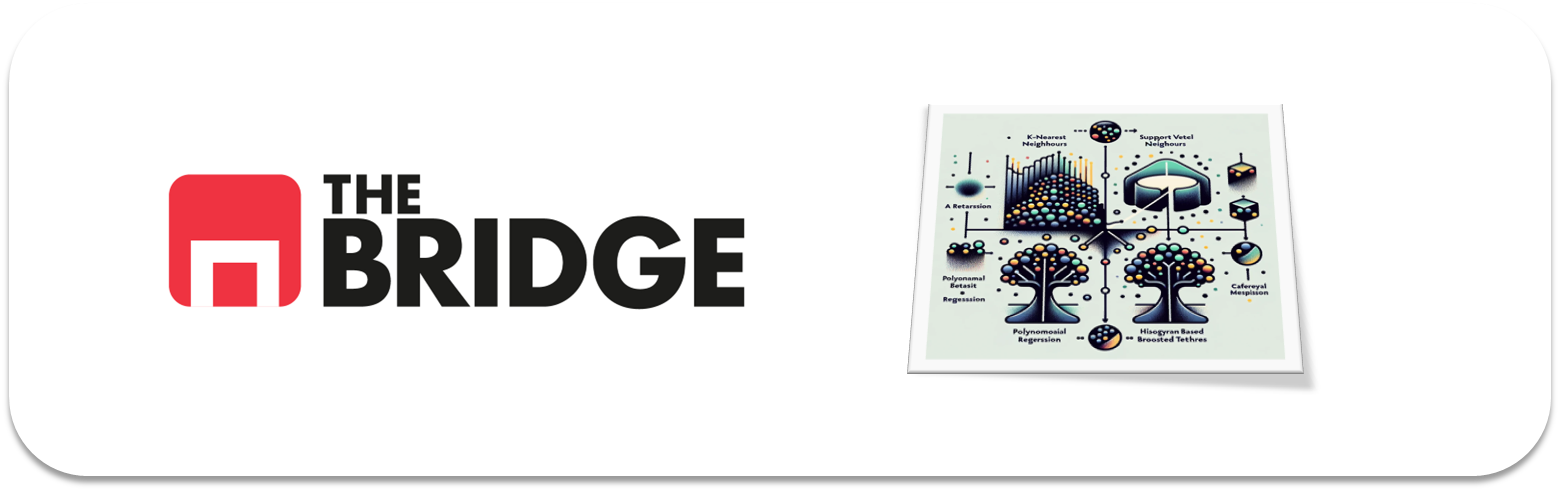

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import plot_importance

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [2]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red


In [5]:
df.nunique()

fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   7
class                     2
dtype: int64

In [6]:
for col in df:
    print(df[col].value_counts())

fixed acidity
6.8     354
6.6     327
6.4     305
7.0     282
6.9     279
       ... 
13.5      1
14.3      1
15.9      1
3.9       1
4.5       1
Name: count, Length: 106, dtype: int64
volatile acidity
0.280    286
0.240    266
0.260    256
0.250    238
0.220    235
        ... 
0.355      1
0.865      1
0.215      1
0.175      1
1.090      1
Name: count, Length: 187, dtype: int64
citric acid
0.30    337
0.28    301
0.32    289
0.49    283
0.26    257
       ... 
1.66      1
0.88      1
0.75      1
1.23      1
0.99      1
Name: count, Length: 89, dtype: int64
residual sugar
2.00     235
1.80     228
1.60     223
1.40     219
1.20     195
        ... 
18.60      1
7.45       1
20.40      1
10.55      1
8.15       1
Name: count, Length: 316, dtype: int64
chlorides
0.044    206
0.036    200
0.042    187
0.046    185
0.048    182
        ... 
0.403      1
0.159      1
0.161      1
0.212      1
0.230      1
Name: count, Length: 214, dtype: int64
free sulfur dioxide
29.0     183
6.0      170

In [7]:
csf_target = 'quality'
reg_target = 'alcohol'

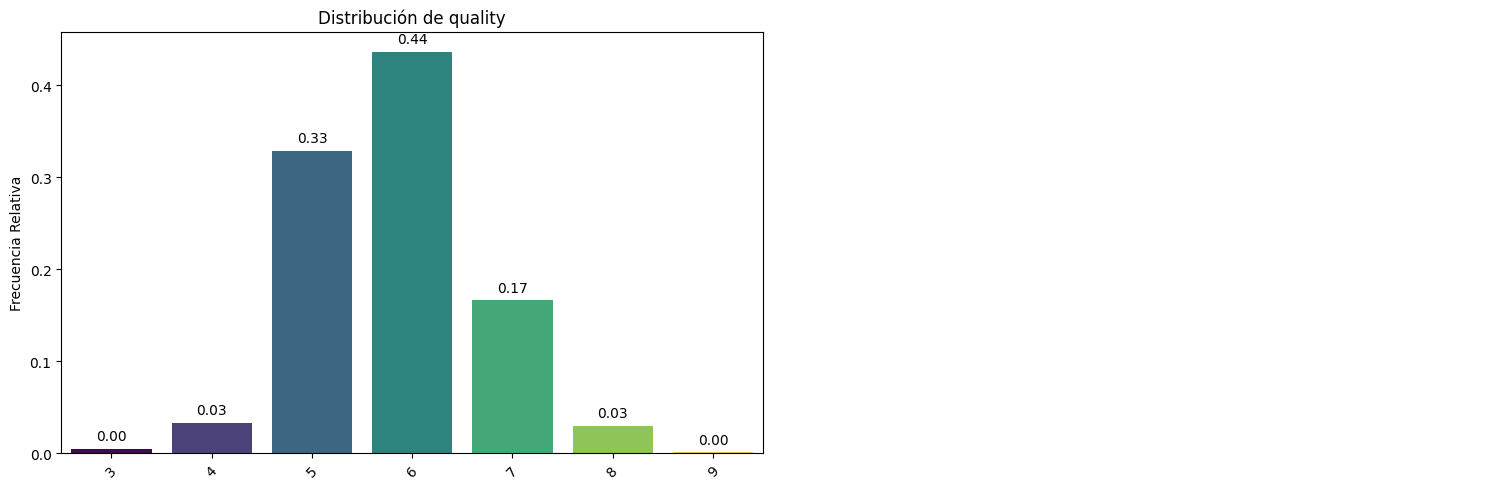

In [8]:
bt.pinta_distribucion_categoricas(df, [csf_target], mostrar_valores = True, relativa = True)

<Axes: xlabel='alcohol', ylabel='Count'>

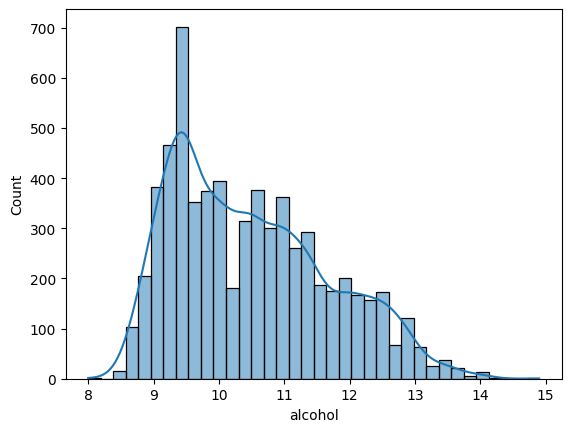

In [9]:
sns.histplot(df[reg_target], kde = True)

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

In [10]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

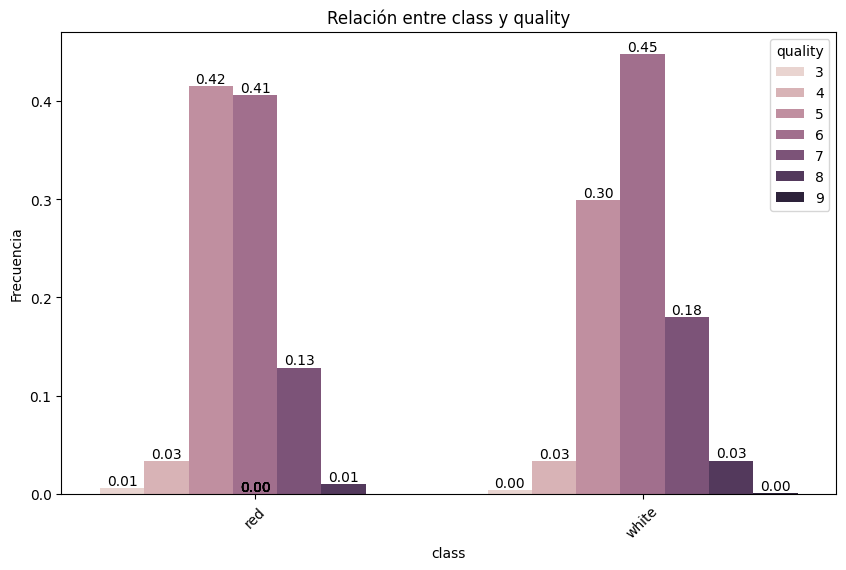

In [11]:
bt.plot_categorical_relationship_fin(train, "class", csf_target, show_values= True, relative_freq= True)

In [12]:
cat_feat_csf = ["class"]
num_feat_csf = [col for col in train.columns if col != "class" and col != cat_feat_csf]
print(len(num_feat_csf))

12


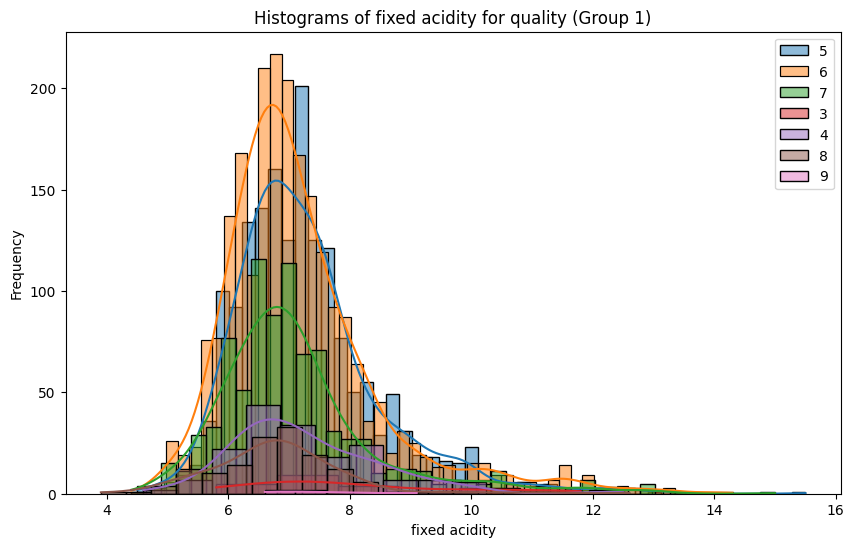

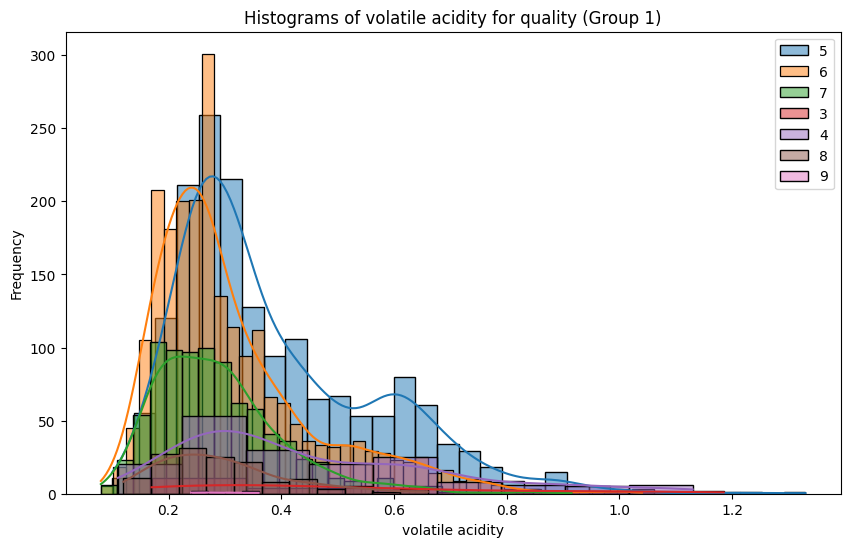

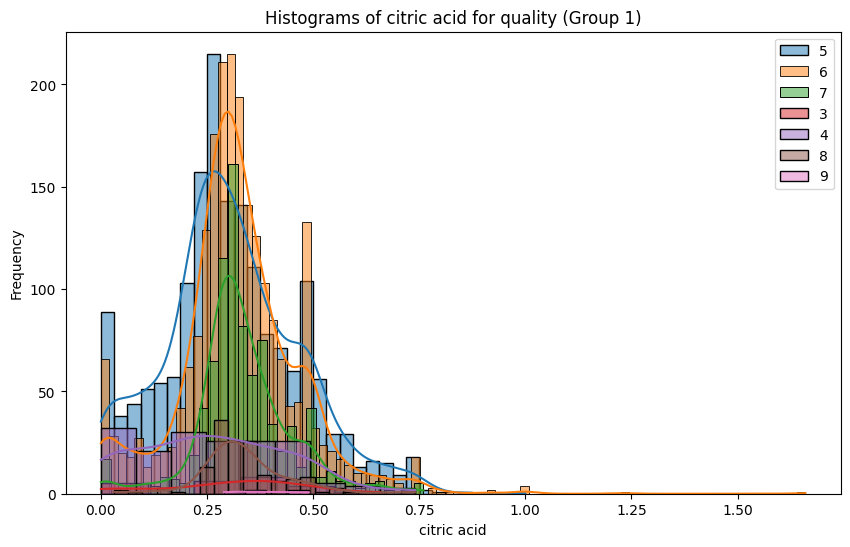

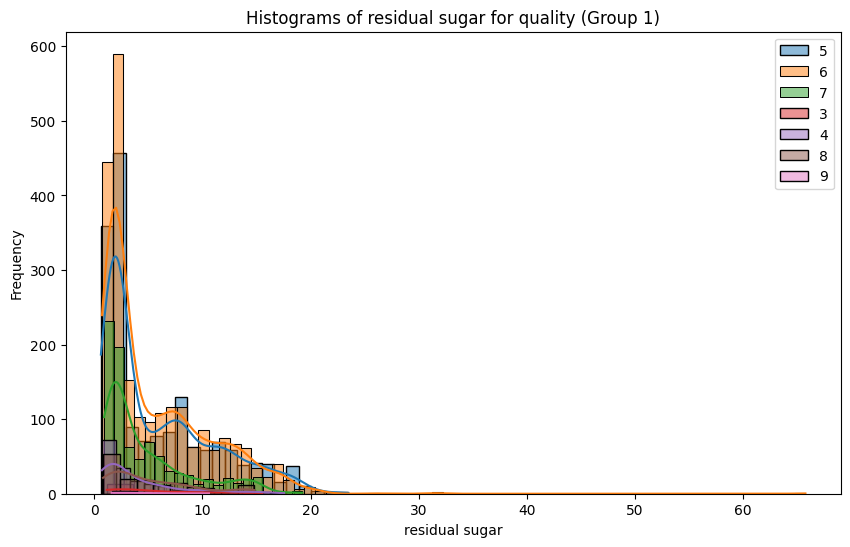

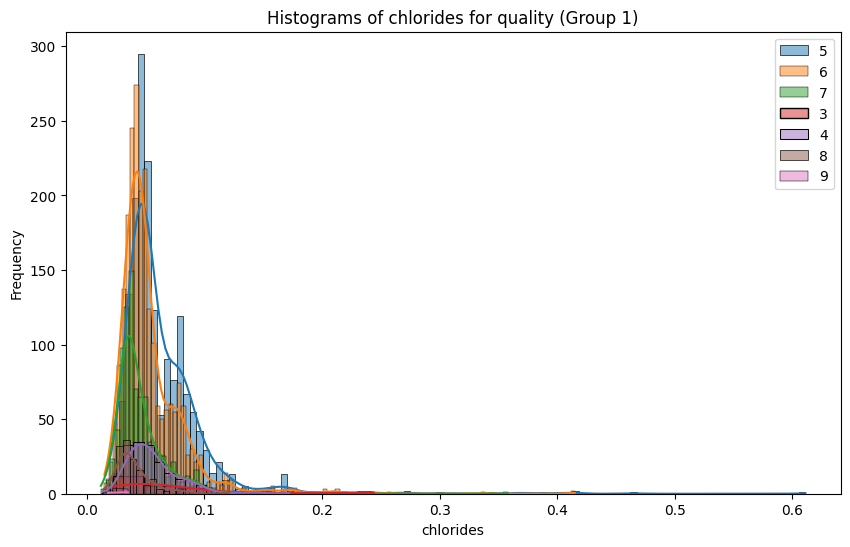

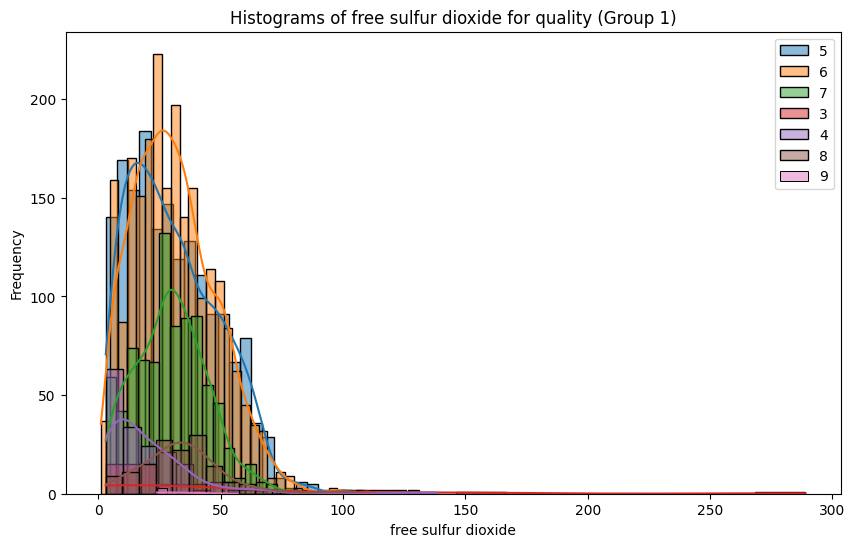

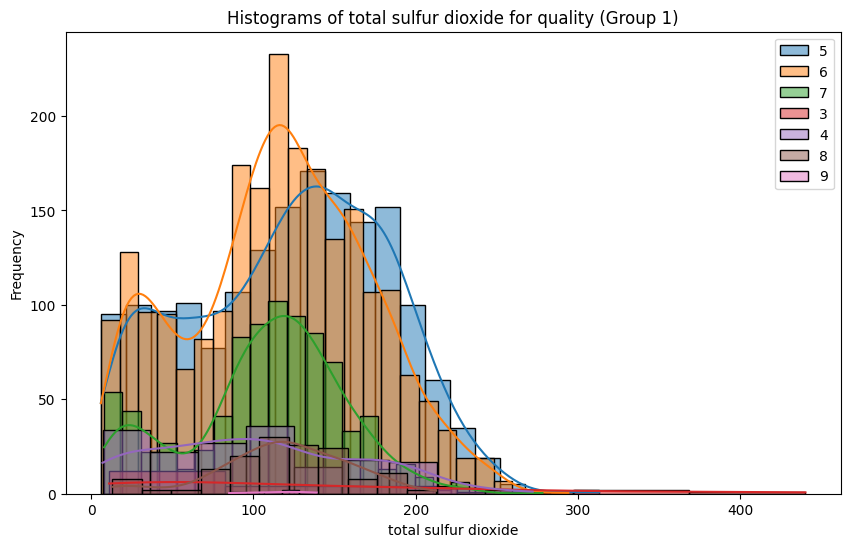

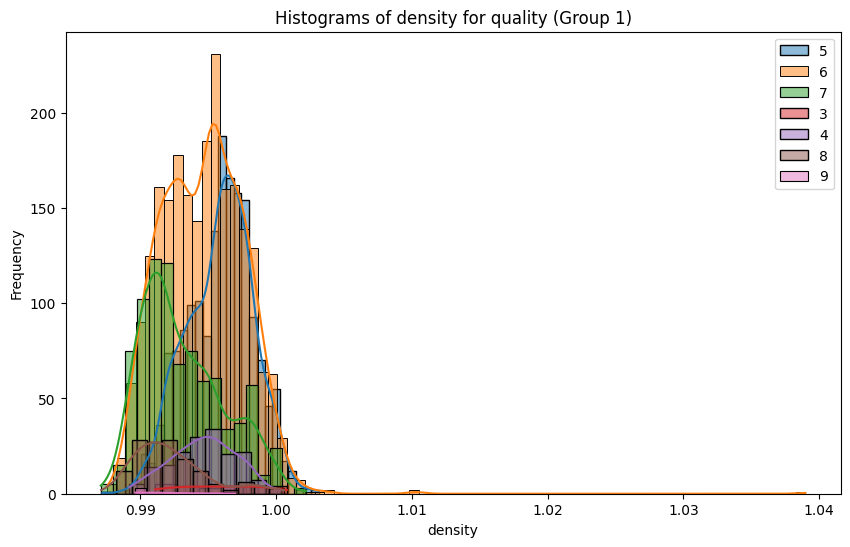

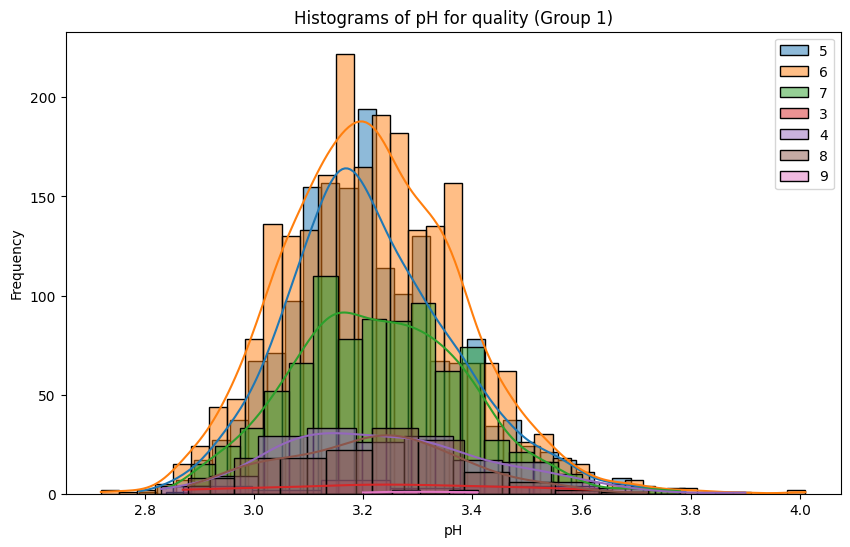

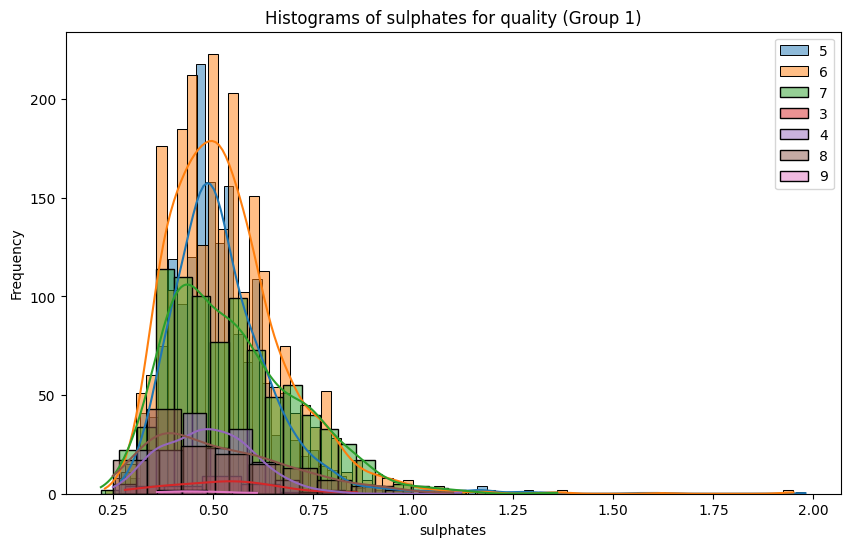

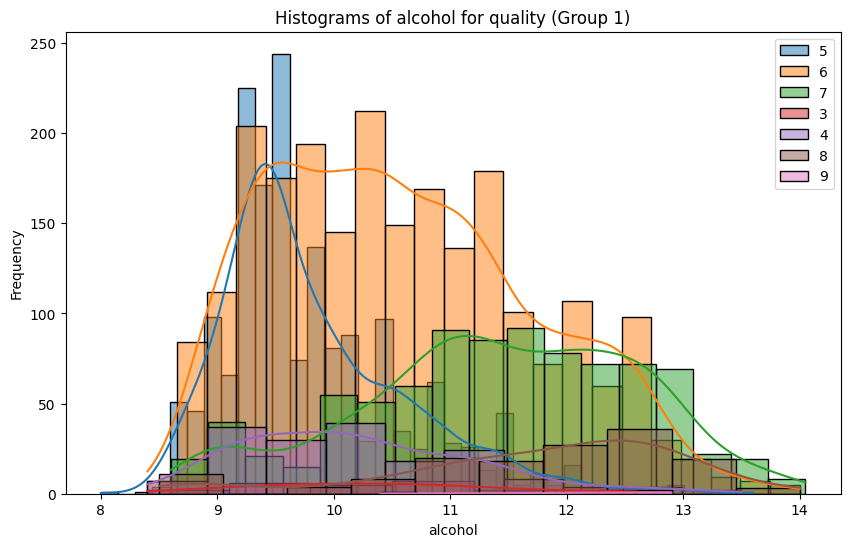

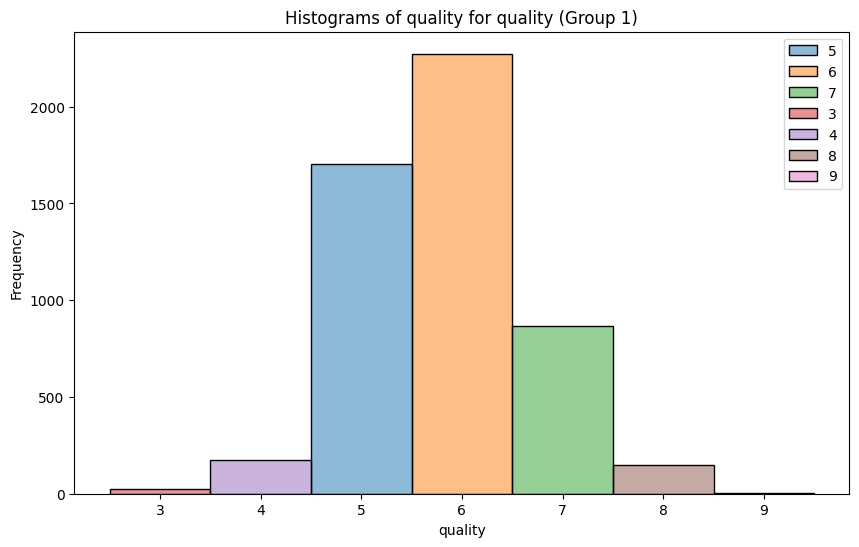

In [13]:
for col in num_feat_csf:
    bt.plot_grouped_histograms(train, cat_col= csf_target, num_col= col, group_size= train[csf_target].nunique())

In [14]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'class'],
      dtype='object')

In [15]:
num_feat_csf_1 = ["volatile acidity","citric acid","chlorides","free sulfur dioxide","total sulfur dioxide", "density","sulphates","alcohol"]
num_feat_csf_2 = ["fixed acidity","residual sugar","pH"]

In [16]:
cat_feat_reg = ["class", "quality"]

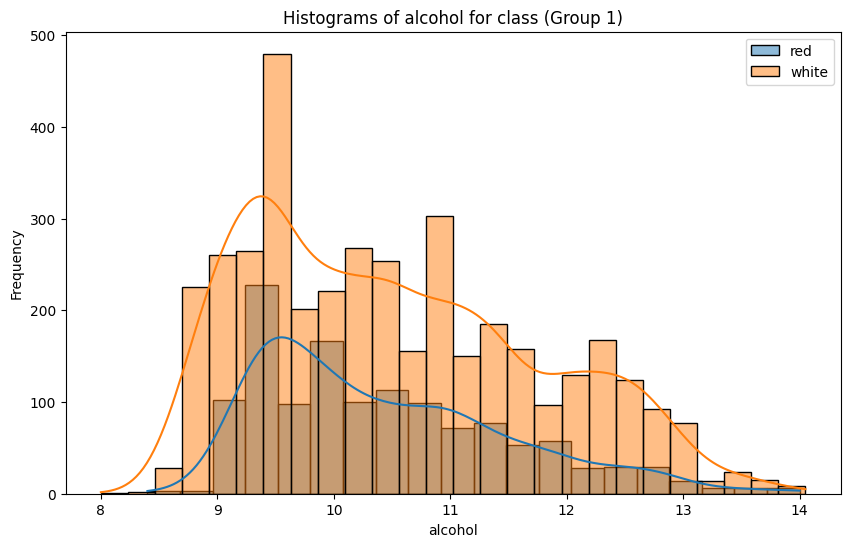

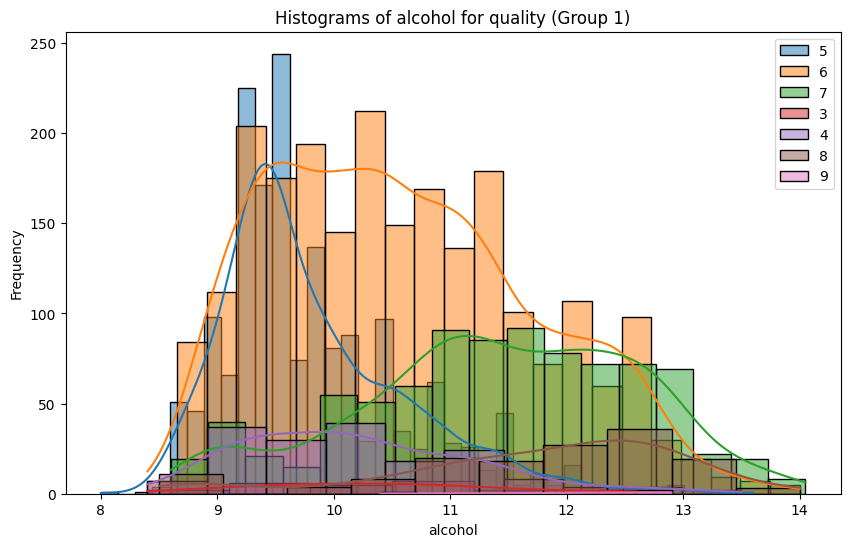

In [17]:
for col in cat_feat_reg:
    bt.plot_grouped_histograms(train, cat_col= col, num_col= reg_target, group_size= train[col].nunique())

In [18]:
cat_feat_reg = ["class","quality"]

In [19]:
num_feat_reg = [col for col in train.columns if col not in cat_feat_reg]
num_feat_reg

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [20]:
corr = train[num_feat_reg].corr(numeric_only= "True")
corrs = np.abs(corr[reg_target]).sort_values(ascending = False)
corrs

alcohol                 1.000000
density                 0.682345
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

In [21]:
r_min = 0.10

num_feats_reg_1 = corrs[corrs > r_min].index.to_list()
num_feats_reg_1.remove(reg_target)

num_feats_reg_2 = [col for col in train.columns if col not in num_feats_reg_1 and col != reg_target
                       and col not in cat_feat_reg]

<Axes: >

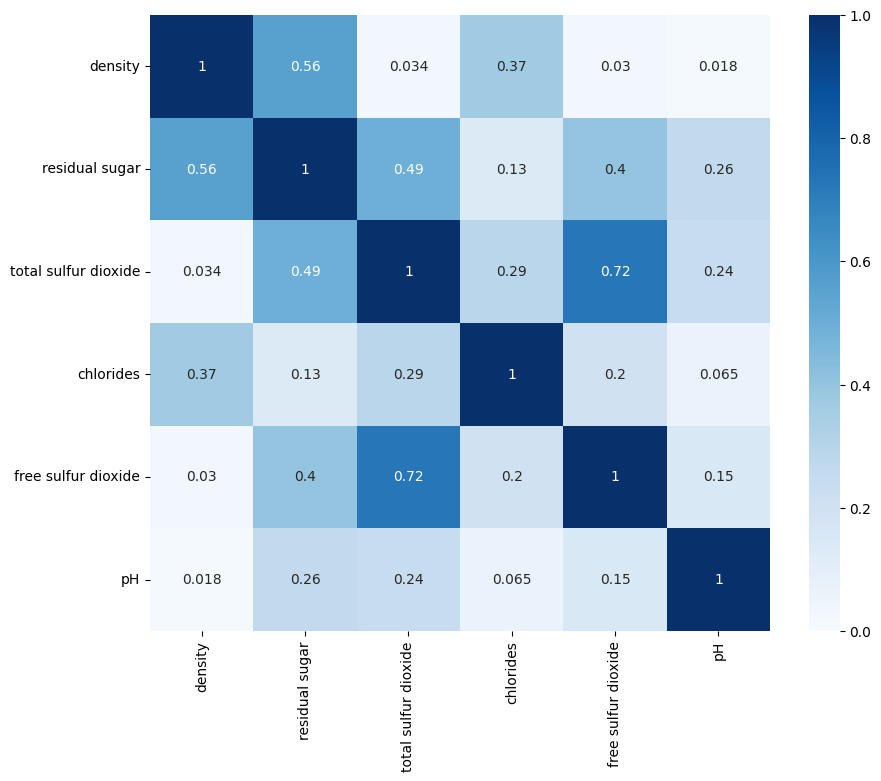

In [22]:
plt.figure(figsize= (10,8))
sns.heatmap(np.abs(train[num_feats_reg_1].corr(numeric_only= "True")), annot= True, cmap = "Blues", vmin= 0, vmax= 1)

In [23]:
num_feats_reg_1.remove("free sulfur dioxide")
num_feats_reg_2.append("free sulfur dioxide")

In [24]:
pd.get_dummies(train["class"], columns="class", drop_first=True, dtype=int)

,white
1916,0
947,1
877,1
2927,1
6063,0
...,...
3772,1
5191,1
5226,1
5390,1


In [25]:
train["class"] = (train["class"] == "white").astype(int)
test["class"] = (test["class"] == "white").astype(int) 

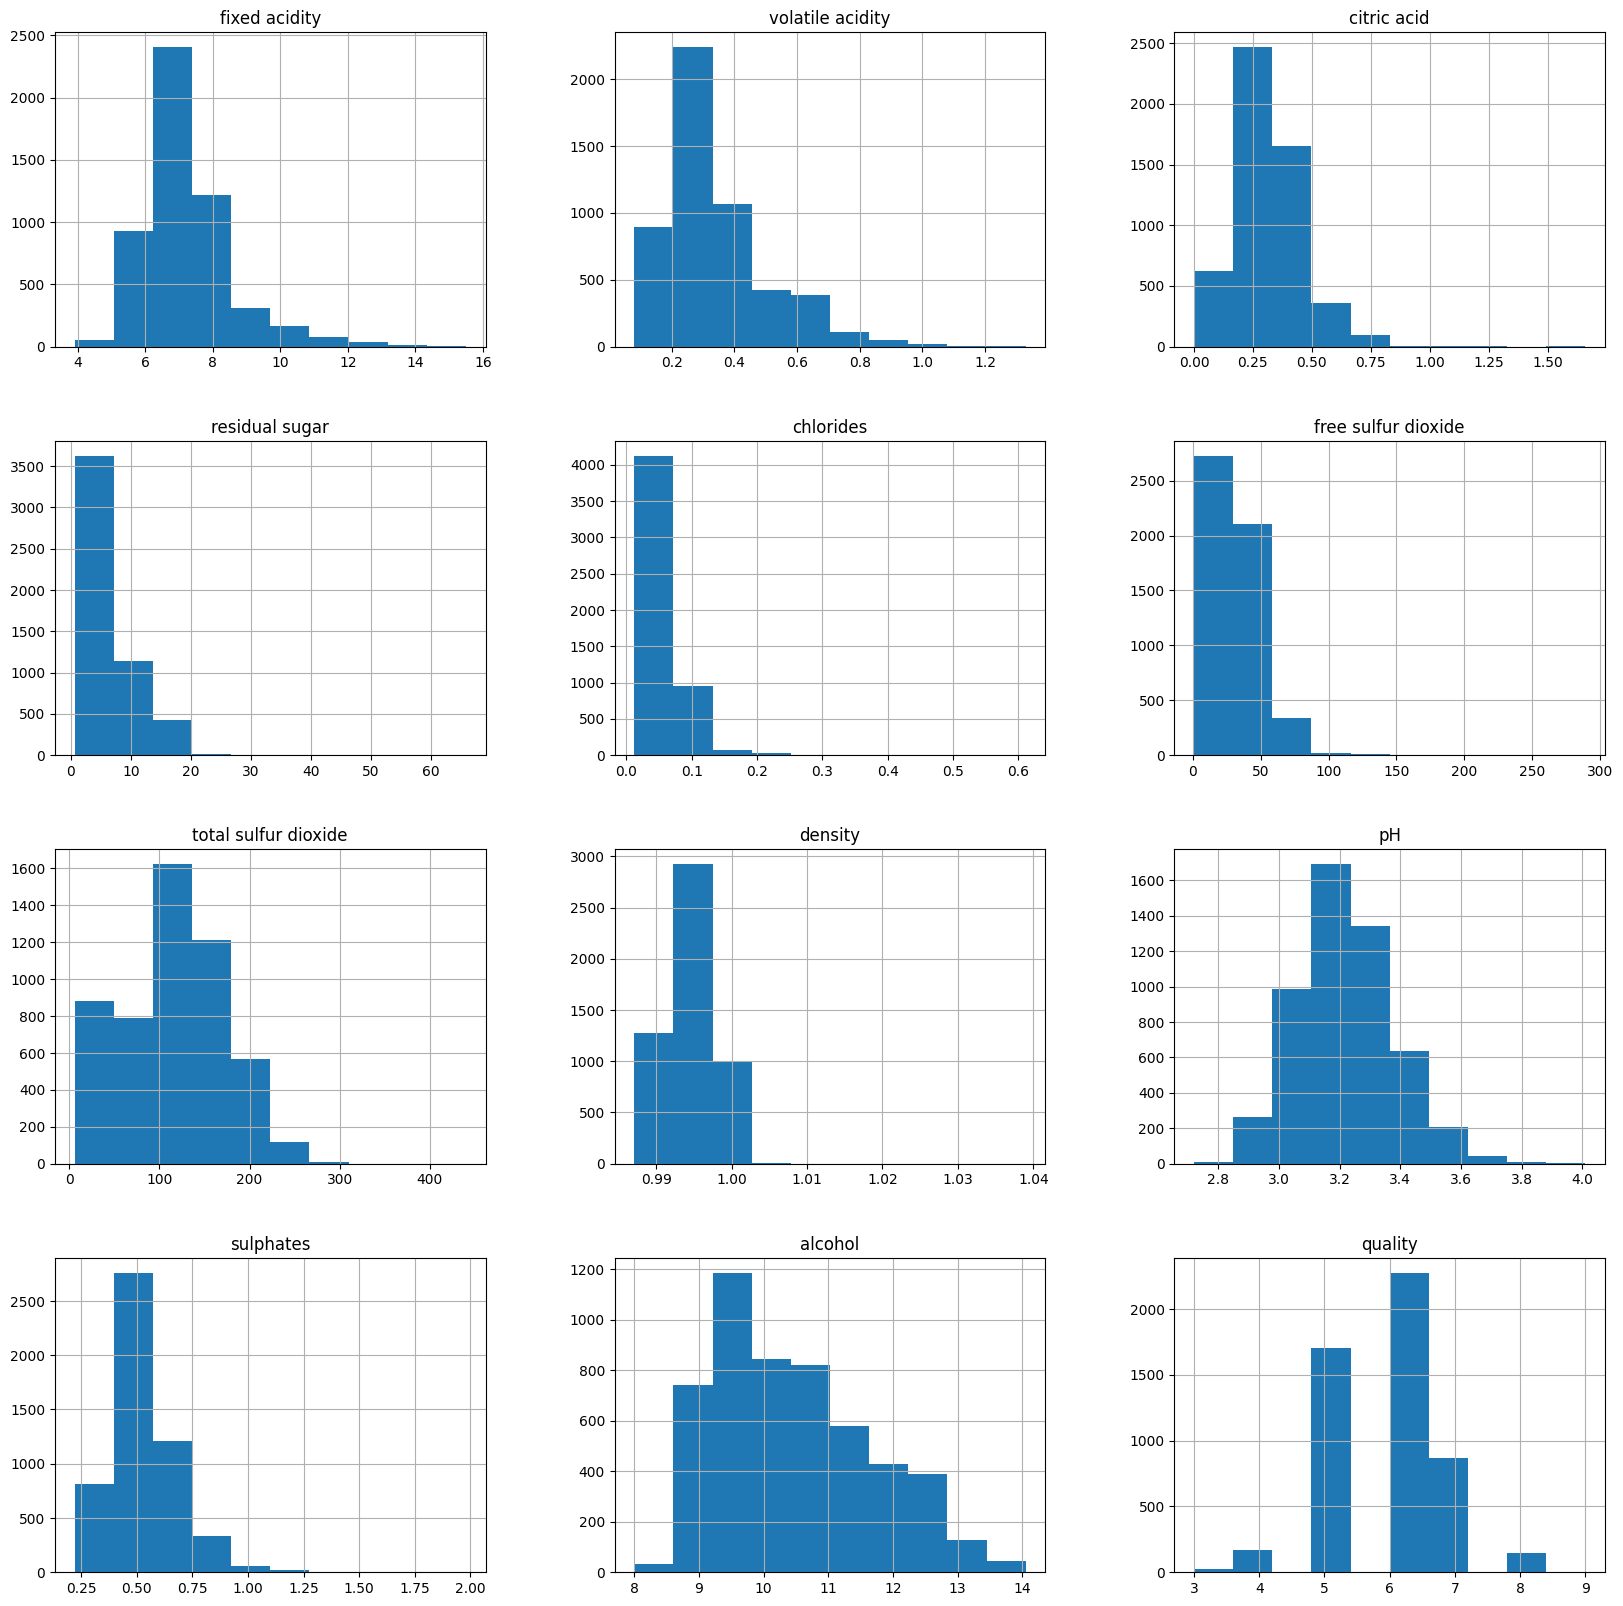

In [26]:
train[num_feat_csf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

In [27]:
train = train[train["citric acid"] > -1]
np.log1p(train["citric acid"])

1916    0.336472
947     0.553885
877     0.215111
2927    0.246860
6063    0.343590
          ...   
3772    0.405465
5191    0.246860
5226    0.322083
5390    0.254642
860     0.246860
Name: citric acid, Length: 5197, dtype: float64

<Axes: xlabel='alcohol', ylabel='Count'>

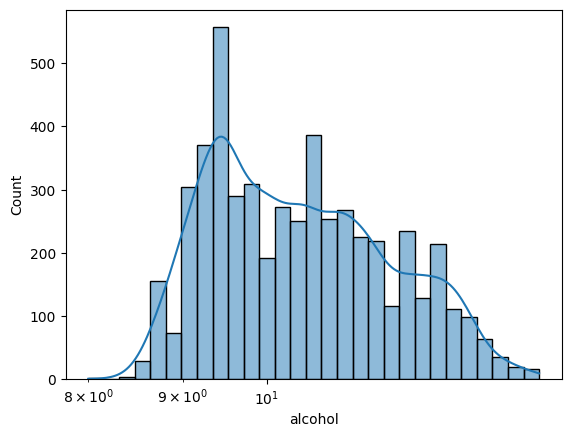

In [28]:
sns.histplot(train["alcohol"], kde=True, log_scale=10)

In [29]:
scaled_train = train.copy()
scaled_test = test.copy()

In [30]:
to_trans = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar", 
    "chlorides",
    "free sulfur dioxide", 
    "total sulfur dioxide",
    "sulphates"
    ]

In [31]:
for col in to_trans:
    move = 0
    if scaled_train[col].min() <= 0:
        desplaza = int(abs(scaled_train[col].min())) + 1
    scaled_train[col] = np.log(scaled_train[col] + move)
    scaled_test[col] = np.log(scaled_test[col] + move)

c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
non_finite_mask = ~np.isfinite(scaled_train[num_feat_csf])
print(scaled_train[num_feat_csf][non_finite_mask.any(axis=1)])

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
952        1.840550         -0.755023         -inf        0.336472  -2.900422   
3469       2.066863         -0.415515         -inf        0.336472  -2.343407   
5619       1.960095         -0.510826         -inf        0.587787  -2.603690   
2627       2.174752         -0.356675         -inf        0.530628  -2.673649   
5071       1.945910         -0.371064         -inf        0.641854  -2.171557   
...             ...               ...          ...             ...        ...   
2976       1.945910         -0.562119         -inf        0.693147  -1.660731   
3696       1.887070         -0.494296         -inf        0.470004  -2.673649   
5068       1.757858         -0.510826         -inf        0.262364  -3.123566   
4191       1.931521         -0.562119         -inf        1.029619  -2.513306   
2612       1.740466         -0.510826         -inf        0.336472  -2.764621   

      free sulfur dioxide  

In [33]:
scaled_train = scaled_train[num_feat_csf].replace([np.inf, -np.inf], np.nan).dropna()
scaled_test = scaled_test[num_feat_csf].replace([np.inf, -np.inf], np.nan).dropna()


In [34]:
np.isinf(train).values.any()

np.False_

In [35]:
np.isinf(scaled_train).values.any()

np.False_

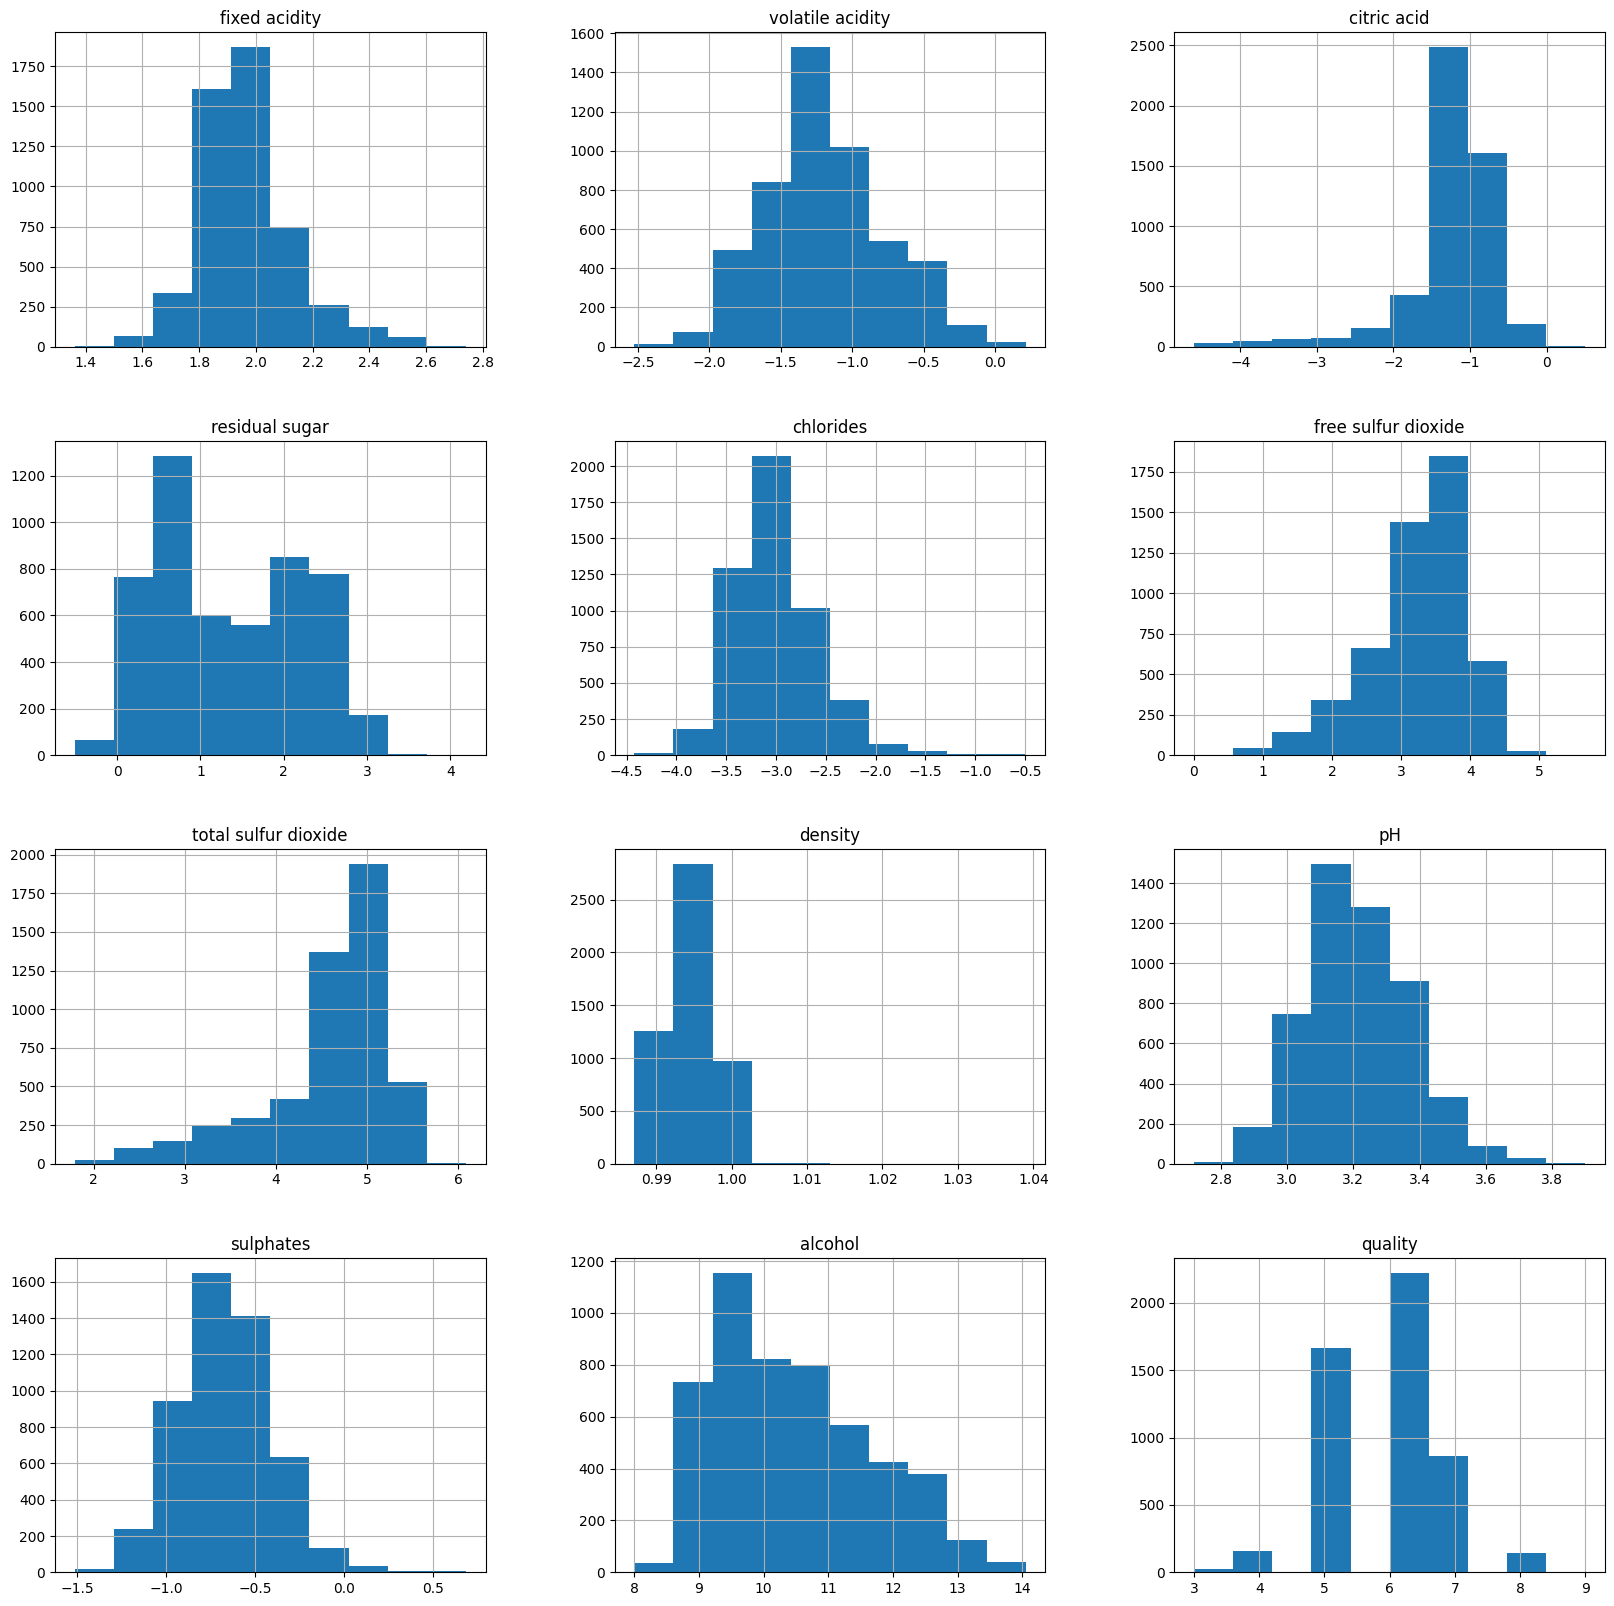

In [36]:
scaled_train[num_feat_csf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

In [37]:
scaler = StandardScaler()

num_feat_reg = num_feat_csf.copy()
num_feat_reg.remove("alcohol") # Alcohol es nuestro target

scaled_train[num_feat_reg] = scaler.fit_transform(scaled_train[num_feat_reg])
scaled_test[num_feat_reg] = scaler.transform(scaled_test[num_feat_reg])

In [38]:
scaled_train[num_feat_reg].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality
count,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03,5.078000e+03
mean,1.108212e-15,-2.532655e-16,1.035450e-16,6.506545e-17,-7.639944e-16,-8.983230e-16,-3.638068e-17,-3.146090e-14,-2.413718e-16,-9.095171e-18,-3.330232e-16
std,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00
min,-3.654029e+00,-3.136761e+00,-5.417891e+00,-2.138608e+00,-3.375205e+00,-4.652549e+00,-4.009460e+00,-2.507771e+00,-3.159785e+00,-3.289835e+00,-3.247595e+00
25%,-6.476358e-01,-6.455030e-01,-2.192939e-01,-8.717650e-01,-6.436253e-01,-5.712347e-01,-2.932839e-01,-7.928140e-01,-6.642311e-01,-6.775652e-01,-9.493178e-01
50%,-1.037275e-01,-9.867650e-02,1.281185e-01,-2.082951e-01,-1.399047e-01,1.981244e-01,2.764187e-01,6.301233e-02,-8.833397e-02,-8.965850e-02,1.998206e-01
75%,4.747653e-01,6.002228e-01,5.397784e-01,8.767813e-01,5.544059e-01,7.316570e-01,6.648303e-01,7.602299e-01,6.635318e-01,6.210298e-01,1.998206e-01
max,4.721164e+00,3.328957e+00,2.838148e+00,3.278159e+00,5.938422e+00,3.510079e+00,2.152466e+00,1.463189e+01,4.390866e+00,5.274932e+00,3.647236e+00


In [39]:
scaled_train_csf = scaled_train.copy()
scaled_test_csf = scaled_test.copy()

scaled_train_csf["alcohol"] = scaler.fit_transform(scaled_train_csf[["alcohol"]])
scaled_test_csf["alcohol"] = scaler.transform(scaled_test_csf[["alcohol"]])

In [40]:
y_train_csf = train[csf_target]
y_test_csf = test[csf_target]
y_train_reg = train[reg_target]
y_test_reg = test[reg_target]


X_train_csf_dict = {}
X_test_csf_dict = {}

X_train_reg_dict = {}
X_test_reg_dict = {}


feats_name = ["cat+num_1", "todas"]
feats = [cat_feat_csf + num_feat_csf_1,
                cat_feat_csf + num_feat_csf_1 + num_feat_csf_2]


for set_name,feature_list in zip(feats_name, feats):
    print(feature_list)
    X_train_csf_dict[set_name] = scaled_train_csf[feature_list]
    X_test_csf_dict[set_name] = scaled_test_csf[feature_list]

# Juegos X_train regresion
    
features_set_name = ["cat+num_1","todas"]
features_set = [cat_feat_reg + num_feats_reg_1,
                cat_feat_reg + num_feats_reg_1 + num_feats_reg_2]

for set_name,feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_reg_dict[set_name] = scaled_train[feature_list]
    X_test_reg_dict[set_name] = scaled_test[feature_list]

['class', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']


KeyError: "['class'] not in index"

In [ ]:
# Instanciamos modelos
knn_csf = KNeighborsClassifier(n_neighbors= 5)
knn_ten_csf = KNeighborsClassifier(n_neighbors= 10)
lr_csf = LogisticRegression(max_iter = 1000)
rf_csf = RandomForestClassifier(max_depth = 10, random_state= 42)
lgb_csf = LGBMClassifier(max_depth = 10, random_state = 42, verbose = -100, n_jobs= -1)

csf_models = {
    "KNN_5": knn_csf,
    "KNN_10": knn_ten_csf,
    "Regresion Logistica": lr_csf,
    "Random Forest": rf_csf,
    "LightGBM": lgb_csf
}

In [ ]:
for feats, X_train in X_train_csf_dict.items():
    print(f"Para el set {feats}:")
    for tipo,modelo in csf_models.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_csf, cv = 5, scoring = "balanced_accuracy")))
    print("******")

In [ ]:
knn_csf = KNeighborsClassifier(n_neighbors= 5, weights= "distance")
knn_ten_csf = KNeighborsClassifier(n_neighbors= 10, weights = "distance")
lr_csf = LogisticRegression(max_iter = 1000, class_weight = "balanced")
rf_rf_csflf = RandomForestClassifier(max_depth = 10, random_state= 42, class_weight = "balanced")
lgb_csf = LGBMClassifier(max_depth = 10, random_state = 42, verbose = -100, class_weight = "balanced", n_jobs=-1)

csf_models = {
    "KNN_5": knn_csf,
    "KNN_10": knn_ten_csf,
    "Regresion Logistica": lr_csf,
    "Random Forest": rf_csf,
    "LightGBM": lgb_csf
}

In [ ]:
for feats, X_train in X_train_csf_dict.items():
    print(f"Para el set {feats}:")
    for tipo,modelo in csf_models.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_csf, cv = 5, scoring = "balanced_accuracy")))
    print("******")

In [ ]:
param_grid = {
    "n_estimators": [100,200,1000],
    "max_depth": [1,5,10,20],
    "learning_rate": [0.1,0.3,0.6,1,0.01],
    "class_weight": ["balanced"]
}

lgb_clf = LGBMClassifier(verbose = -100, n_jobs= -1)

lgb_grid = GridSearchCV(lgb_clf,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "balanced_accuracy")

lgb_grid.fit(X_train_csf_dict["todas"], y_train_csf)

In [ ]:
print(lgb_grid.best_params_)
print(lgb_grid.best_score_)

In [ ]:
print(lgb_grid.get_params())

In [ ]:
lgb_grid.best_estimator_

In [ ]:
lgb_grid.best_estimator_.feature_importances_

In [ ]:
plot_importance(lgb_grid.best_estimator_,
                importance_type="split",
                figsize=(7,6),
                title="LightGBM Feature Importance (Split)")
plt.show()

In [ ]:
plot_importance(lgb_grid.best_estimator_,
                importance_type="gain",
                figsize=(7,6),
                title="LightGBM Feature Importance (Gain)")
plt.show()

In [ ]:
y_pred = lgb_grid.best_estimator_.predict(X_test_csf_dict["todas"])

print(classification_report(y_test_csf, y_pred, zero_division= 0.0))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_csf, y_pred)

plt.show()

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [ ]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)

modelos_reg = {
    "Random Forest": rf_reg,
    "LightGBM": lgb_reg,
    "XGBoost Regressor": xgb_reg
}

In [ ]:
for feature_set, X_train in X_train_reg_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_reg.items():
        print(f"{tipo}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, X_train, y_train_reg, cv = 5, scoring = "neg_mean_absolute_percentage_error")))
    print("******")

In [ ]:
param_grid = {
    "n_estimators": [100,200,1000],
    "max_depth": [1,5,10,20],
    "max_features": ["log2","sqrt", None]
}

rf_reg = RandomForestRegressor()

rf_grid = GridSearchCV(rf_reg,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "neg_mean_absolute_percentage_error",
                       n_jobs= -1)

rf_grid.fit(X_train_reg_dict["todas"], y_train_reg)

In [ ]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

In [ ]:
y_pred = rf_grid.best_estimator_.predict(X_test_reg_dict["todas"])
print("MAPE:", mean_absolute_percentage_error(y_test_reg, y_pred))

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test_reg, alpha=0.5)
plt.xlabel("Valores Predichos")
plt.ylabel("Valores Reales")

max_value = max(max(y_test_reg), max(y_pred))
min_value = min(min(y_test_reg), min(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], 'r')

plt.title("Comparación de Valores Reales vs. Predichos")
plt.show()

In [ ]:
pd.DataFrame({"features": rf_grid.best_estimator_.feature_names_in_ , "importance": rf_grid.best_estimator_.feature_importances_}).sort_values("importance",ascending=False)